<a href="https://colab.research.google.com/github/Mrfrktmrck19/Convolutional-autoencoder-for-image-denoising/blob/main/Preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoder for Image Denoising 


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


In [2]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


In [3]:
def noise(array, cuda:bool):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    
    if cuda:
        return np.clip(noisy_array, 0.0, 1.0).cuda()
    else:
        return np.clip(noisy_array, 0.0, 1.0)

In [4]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()
# Setup-End

In [5]:
# Preparing the data - Start
def preparingData(display_bool:bool, cuda:bool):
    """
        Returns noisy train data and noisy test data
        params: display->bool 
        params: cuda   ->bool
    """
    # Since we only need images from the dataset to encode and decode, we
    # won't use the labels.
    (train_data, _), (test_data, _) = mnist.load_data()

    # Normalize and reshape the data
    train_data = preprocess(train_data)
    test_data = preprocess(test_data)

    # Create a copy of the data with added noise
    noisy_train_data = noise(train_data, cuda)
    noisy_test_data = noise(test_data, cuda)
    
    if display:
        # Display the train data and a version of it with added noise
        display(train_data, noisy_train_data)
    
    return train_data, test_data, noisy_train_data, noisy_test_data

# Preparing the data - End


## T_L.py

In [6]:
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, UpSampling2D, Input
import keras
from keras.models import Sequential, Model
import tensorflow as tf
from tqdm import tqdm
import cv2 as cv


Converts gray images which has one channel to RGB images which has three channel, so that we can put dataset properly to VggModel that needs inputs with three channels in following function:

In [7]:
def channelOne2Three(dataset):
    dataset_list = []
    for data in tqdm(dataset):
        data = cv.cvtColor(data, cv.COLOR_GRAY2BGR)
        dataset_list.append(data)
    dataset = np.array(dataset_list)
    return dataset

vggmodel = VGG16(include_top=False, input_shape=((32, 32, 3)))


Prepares VggModel to transfer learning by doing assignment "False" value to all layers of the model.

In [8]:
for layer in vggmodel.layers:
    layer.trainable = False

Split the data set to train and test.
@params: display=bool,cuda=bool

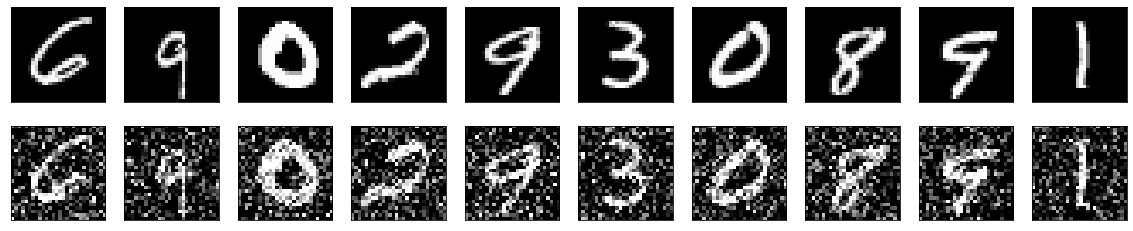

In [9]:
train_data, test_data, noisy_train, noisy_test = preparingData(False, cuda = False)


The image above is generated with nosies.

In [10]:
train_data = train_data.reshape((60000, 28,28,1))
noisy_train = noisy_train.reshape((60000, 28,28,1))

noisy_train = channelOne2Three(noisy_train.astype(np.float32))

test_data = test_data.reshape((10000, 28,28,1))
noisy_test = noisy_test.reshape((10000, 28,28,1)).astype(np.float32)
noisy_test_model = channelOne2Three(noisy_test)

100%|██████████| 10000/10000 [00:00<00:00, 70336.46it/s]


In [11]:
model = Sequential()

# Expands size of the inputs for giving data to VggModel properly
model.add(keras.layers.ZeroPadding2D(padding=(2, 2), input_shape=(28, 28, 3)))

# Adds VggModel which is used to transfer learning to the model.
# This part is encoder part of the model.
model.add(vggmodel)     

#This part is decoder part of the model.
model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(1,1,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='relu', padding='valid'))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='valid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 32, 32, 3)        0         
 2D)                                                             
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 2, 2, 128)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          7

In [13]:
opr = tf.keras.optimizers.Adam(learning_rate = 1e-2)
model.compile(optimizer=opr, loss='binary_crossentropy' , metrics=['BinaryAccuracy', 'accuracy'])

model.fit(
    x=noisy_train,
    y=train_data,
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_model, test_data),
)

Epoch 1/3
469/469 [==============================] - 762s 2s/step - loss: 0.2280 - binary_accuracy: 0.7934 - accuracy: 0.7934 - val_loss: 0.2215 - val_binary_accuracy: 0.7907 - val_accuracy: 0.7907
Epoch 2/3
469/469 [==============================] - 739s 2s/step - loss: 0.2216 - binary_accuracy: 0.7931 - accuracy: 0.7931 - val_loss: 0.2200 - val_binary_accuracy: 0.7917 - val_accuracy: 0.7917
Epoch 3/3
469/469 [==============================] - 739s 2s/step - loss: 0.2206 - binary_accuracy: 0.7929 - accuracy: 0.7929 - val_loss: 0.2206 - val_binary_accuracy: 0.7929 - val_accuracy: 0.7929


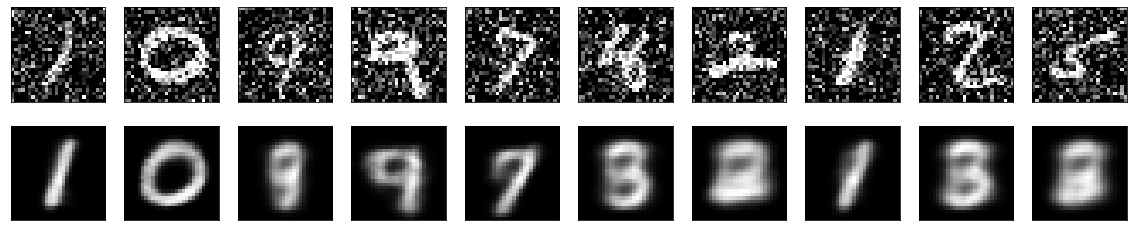

In [14]:
# Predictions
predictions = model.predict(noisy_test_model)
display(noisy_test, predictions)

